## Importação das Bibliotecas

In [1]:
# Importar as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import urllib.request
import zipfile
import os


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Comando para baixar os dados (descomente para executar)
#urllib.request.urlretrieve("https://files.grouplens.org/datasets/movielens/ml-1m.zip", "ml-1m.zip")

# Descompactar o arquivo
with zipfile.ZipFile("ml-1m.zip", 'r') as zip_ref:
    zip_ref.extractall("ml-1m")


In [4]:
# Carregar os dados em dataframes
ratings = pd.read_csv('ml-1m/ml-1m/ratings.dat', sep='::', header=None, engine='python', names=['user_id', 'movie_id', 'rating', 'timestamp'], encoding='latin1')
movies = pd.read_csv('ml-1m/ml-1m/movies.dat', sep='::', header=None, engine='python', names=['movie_id', 'title', 'genres'], encoding='latin1')
users = pd.read_csv('ml-1m/ml-1m/users.dat', sep='::', header=None, engine='python', names=['user_id', 'gender', 'age', 'occupation', 'zip_code'], encoding='latin1')


In [5]:

users.head()


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [6]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [7]:

movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


## Análise Exploratória dos Dados
Nesta seção, exploraremos os dados para entender sua estrutura e obter insights iniciais.


Número de usuários: 6040
Número de filmes: 3706
Número de avaliações: 1000209


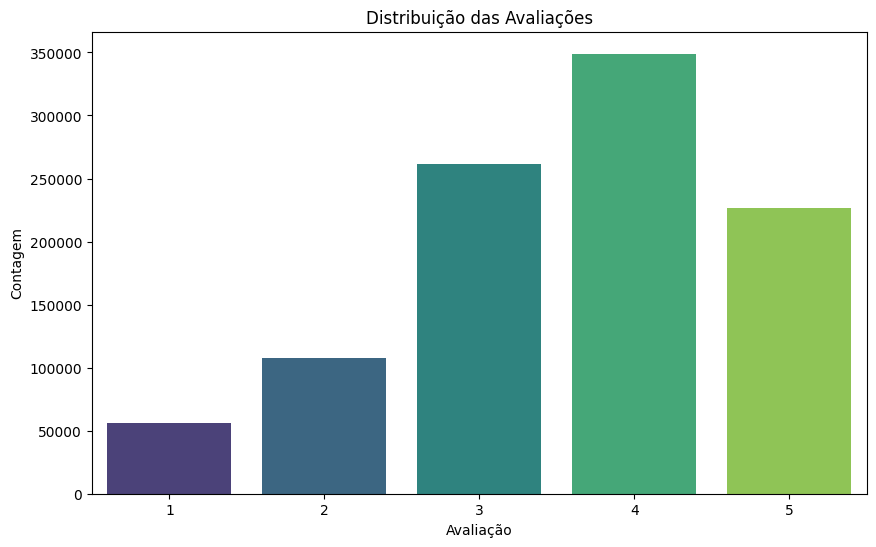

In [8]:
# Informações básicas
num_users = ratings['user_id'].nunique()
num_movies = ratings['movie_id'].nunique()
num_ratings = ratings.shape[0]

print(f'Número de usuários: {num_users}')
print(f'Número de filmes: {num_movies}')
print(f'Número de avaliações: {num_ratings}')

# Distribuição das avaliações
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings, palette="viridis")
plt.title('Distribuição das Avaliações')
plt.xlabel('Avaliação')
plt.ylabel('Contagem')
plt.show()


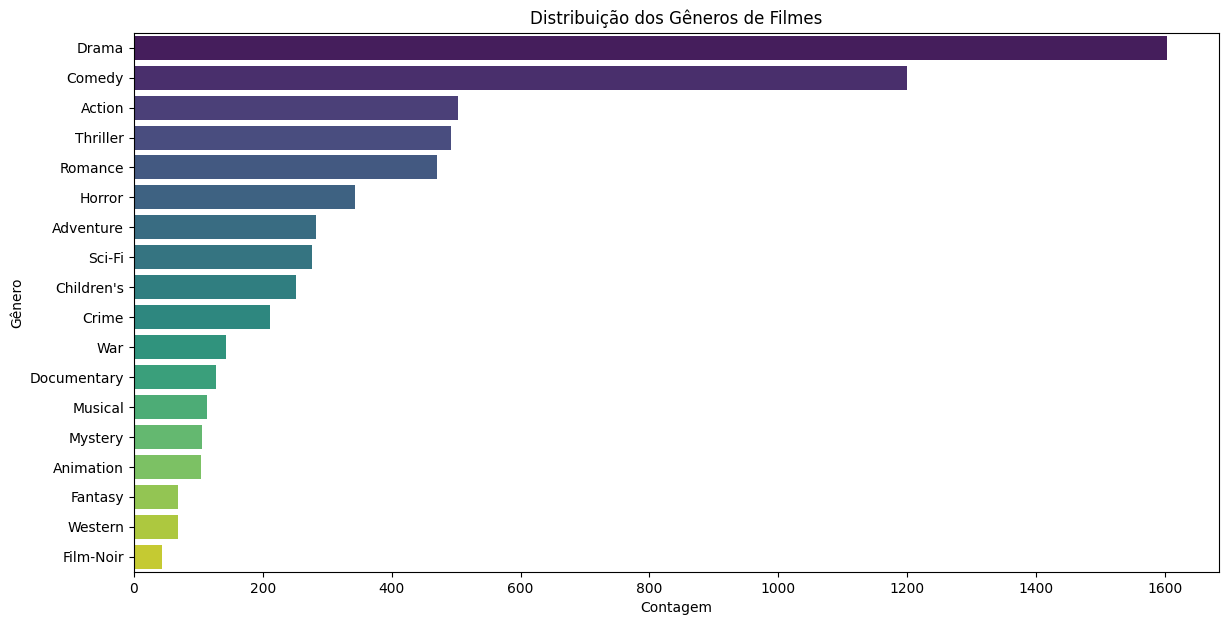

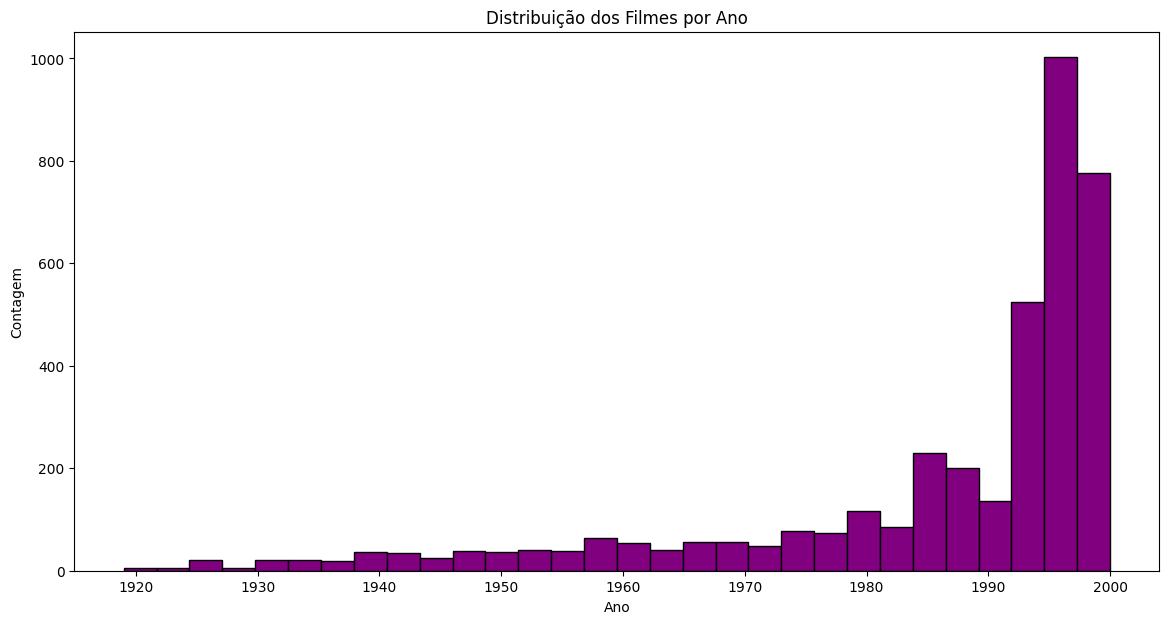

In [9]:
# Separar gêneros
genres = movies['genres'].str.split('|', expand=True).stack().reset_index(level=1, drop=True)
genres.name = 'genre'
movies_genres = movies[['movie_id', 'title']].join(genres)

# Distribuição dos gêneros
plt.figure(figsize=(14, 7))
sns.countplot(y=genres, order=genres.value_counts().index, palette="viridis")
plt.title('Distribuição dos Gêneros de Filmes')
plt.xlabel('Contagem')
plt.ylabel('Gênero')
plt.show()

# Filmes por ano
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')
movies['year'] = pd.to_numeric(movies['year'], errors='coerce')

plt.figure(figsize=(14, 7))
movies['year'].dropna().astype(int).plot(kind='hist', bins=30, color='purple', edgecolor='black')
plt.title('Distribuição dos Filmes por Ano')
plt.xlabel('Ano')
plt.ylabel('Contagem')
plt.show()


## Pré-processamento dos Dados
Nesta seção, realizaremos o pré-processamento dos dados, incluindo a verificação de duplicatas, normalização e construção de matrizes de distância.


In [10]:
# Verificar duplicatas
print(f'Duplicatas nas avaliações: {ratings.duplicated().sum()}')
print(f'Duplicatas nos filmes: {movies.duplicated().sum()}')
print(f"Duplicated users: {users.duplicated().sum()}")

# Pivotar a matriz de avaliações para criar uma matriz de usuário-filme
user_movie_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)





Duplicatas nas avaliações: 0
Duplicatas nos filmes: 0
Duplicated users: 0


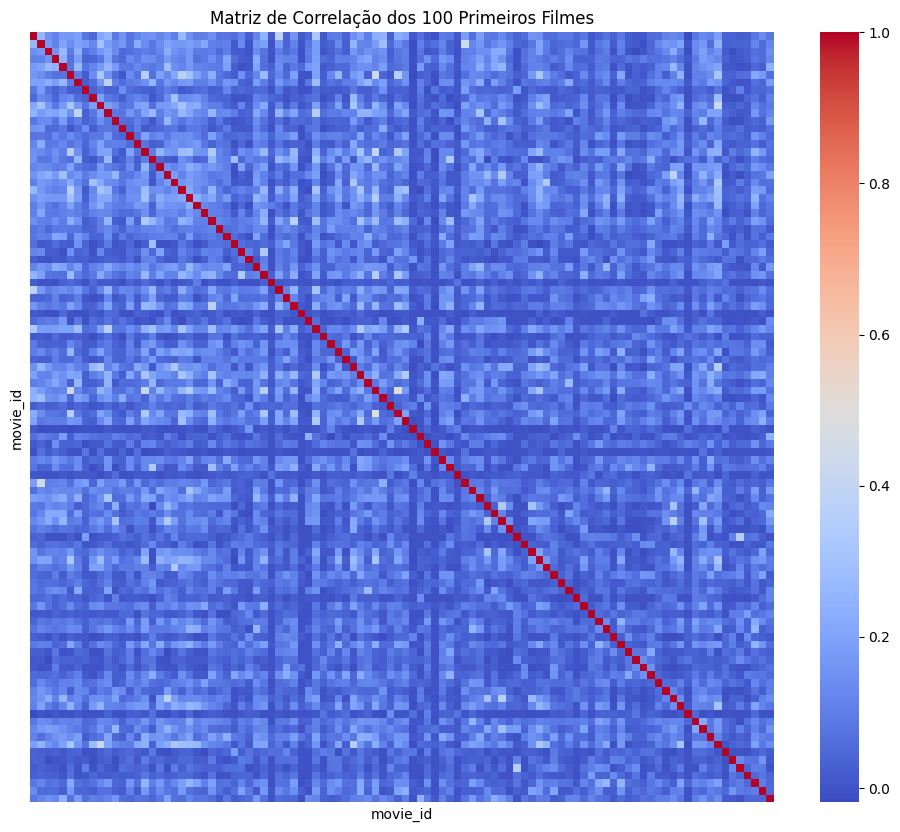

In [11]:
# Selecionar um subconjunto dos dados para a matriz de correlação
subset_user_movie_matrix = user_movie_matrix.iloc[:, :100]  # Selecionar os 100 primeiros filmes

# Calcular a matriz de correlação para o subconjunto
corr_matrix = subset_user_movie_matrix.corr()

# Plotar a matriz de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', xticklabels=False, yticklabels=False)
plt.title('Matriz de Correlação dos 100 Primeiros Filmes')
plt.show()


In [12]:
# Normalização dos dados (apenas se necessário)
scaler = StandardScaler()
user_movie_matrix_normalized = scaler.fit_transform(user_movie_matrix)

user_movie_matrix_normalized = pd.DataFrame(user_movie_matrix_normalized, index=user_movie_matrix.index, columns=user_movie_matrix.columns)

user_movie_matrix_normalized.head()


movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.758734,-0.344462,-0.274956,-0.159317,-0.214328,-0.415292,-0.274471,-0.101751,-0.121857,-0.400567,...,-0.11754,-0.032983,-0.069767,-0.117019,-0.090777,-0.390685,-0.223267,-0.091368,-0.078855,-0.253864
2,-0.701718,-0.344462,-0.274956,-0.159317,-0.214328,-0.415292,-0.274471,-0.101751,-0.121857,-0.400567,...,-0.11754,-0.032983,-0.069767,-0.117019,-0.090777,-0.390685,-0.223267,-0.091368,-0.078855,-0.253864
3,-0.701718,-0.344462,-0.274956,-0.159317,-0.214328,-0.415292,-0.274471,-0.101751,-0.121857,-0.400567,...,-0.11754,-0.032983,-0.069767,-0.117019,-0.090777,-0.390685,-0.223267,-0.091368,-0.078855,-0.253864
4,-0.701718,-0.344462,-0.274956,-0.159317,-0.214328,-0.415292,-0.274471,-0.101751,-0.121857,-0.400567,...,-0.11754,-0.032983,-0.069767,-0.117019,-0.090777,-0.390685,-0.223267,-0.091368,-0.078855,-0.253864
5,-0.701718,-0.344462,-0.274956,-0.159317,-0.214328,0.960662,-0.274471,-0.101751,-0.121857,-0.400567,...,-0.11754,-0.032983,-0.069767,-0.117019,-0.090777,-0.390685,-0.223267,-0.091368,-0.078855,-0.253864


## Aplicação dos Algoritmos de Clusterização
Nesta seção, aplicaremos diferentes algoritmos de clusterização, incluindo K-means, DBSCAN e Clustering Hierárquico.


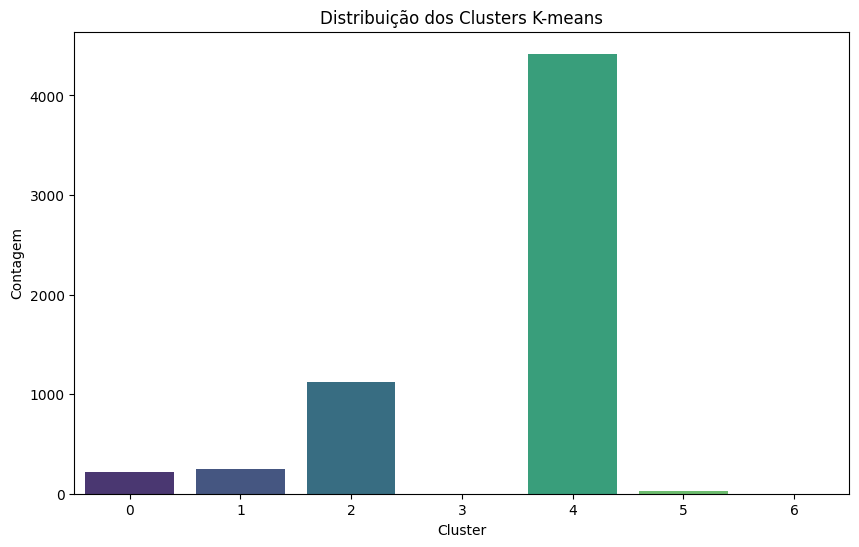

Silhouette Score para K-means: 0.21674598515094248


In [13]:
# Aplicar K-means
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans_clusters = kmeans.fit_predict(user_movie_matrix_normalized)

# Adicionar rótulos de cluster ao dataframe de usuários
users = pd.DataFrame(index=user_movie_matrix.index)
users['cluster_kmeans'] = kmeans_clusters

# Verificar a distribuição dos clusters K-means
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster_kmeans', data=users, palette="viridis")
plt.title('Distribuição dos Clusters K-means')
plt.xlabel('Cluster')
plt.ylabel('Contagem')
plt.show()

# Silhouette Score para K-means
silhouette_kmeans = silhouette_score(user_movie_matrix_normalized, kmeans_clusters)
print(f'Silhouette Score para K-means: {silhouette_kmeans}')


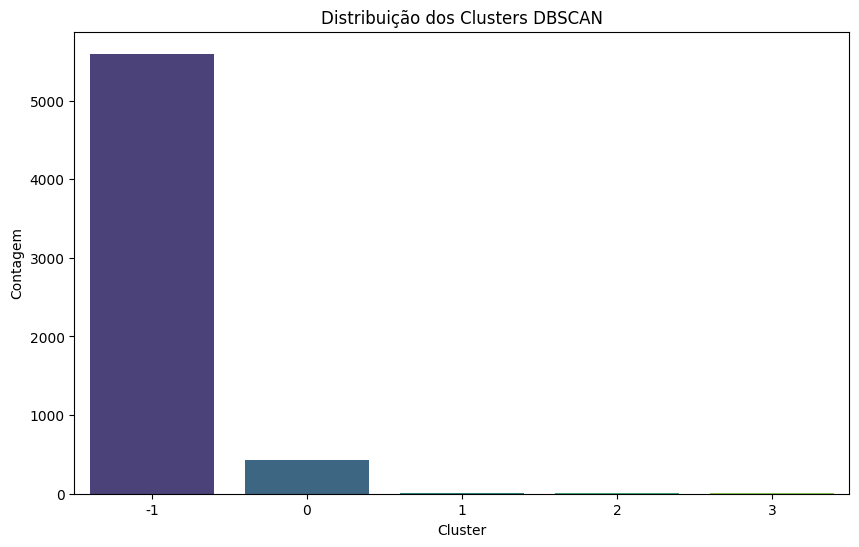

Silhouette Score para DBSCAN: -0.06653719808869239


In [14]:
# Aplicar DBSCAN com os melhores parâmetros
dbscan = DBSCAN(metric='cosine', eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(user_movie_matrix_normalized)

# Adicionar rótulos de cluster ao dataframe de usuários
users['cluster_dbscan'] = dbscan_clusters

# Verificar a distribuição dos clusters DBSCAN
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster_dbscan', data=users, palette="viridis")
plt.title('Distribuição dos Clusters DBSCAN')
plt.xlabel('Cluster')
plt.ylabel('Contagem')
plt.show()

# Silhouette Score para DBSCAN
n_clusters_dbscan = len(set(dbscan_clusters)) - (1 if -1 in dbscan_clusters else 0)
if n_clusters_dbscan > 1:
    silhouette_dbscan = silhouette_score(user_movie_matrix_normalized, dbscan_clusters, metric='cosine')
    print(f'Silhouette Score para DBSCAN: {silhouette_dbscan}')
else:
    print('DBSCAN resultou em um único cluster ou todos os pontos como ruído.')


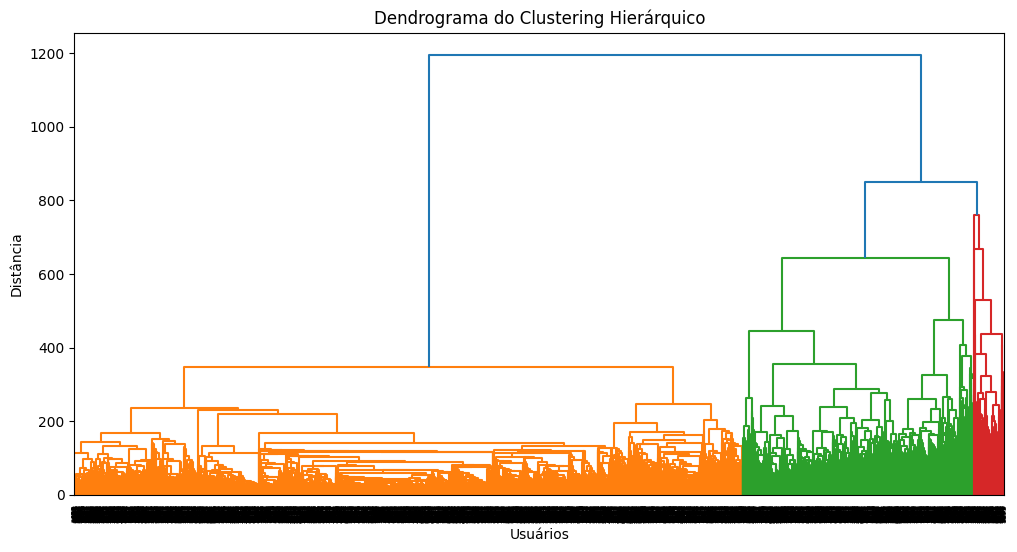

Número de clusters obtidos: 10
Silhouette Score for Hierarchical Clustering: 0.19609721551663264


In [15]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score

# Aplicar o clustering hierárquico com linkagem 'ward'
hierarchical_clustering = linkage(user_movie_matrix_normalized, method='ward')

# Plotar o dendrograma
plt.figure(figsize=(12, 6))
dendrogram(hierarchical_clustering)
plt.title('Dendrograma do Clustering Hierárquico')
plt.xlabel('Usuários')
plt.ylabel('Distância')
plt.show()

# Determinar o número de clusters cortando o dendrograma
num_clusters_hierarchical = 10  # Ajuste conforme necessário

# Obter os rótulos dos clusters
hierarchical_clusters = fcluster(hierarchical_clustering, num_clusters_hierarchical, criterion='maxclust')

# Exibir o número de clusters obtidos
print(f'Número de clusters obtidos: {len(np.unique(hierarchical_clusters))}')

# Avaliar a qualidade dos clusters usando Silhouette Score
silhouette_avg_hierarchical = silhouette_score(user_movie_matrix_normalized, hierarchical_clusters)
print(f'Silhouette Score for Hierarchical Clustering: {silhouette_avg_hierarchical}')




In [17]:
users.head()

,cluster_kmeans,cluster_dbscan
user_id,,
1,4,-1
2,4,-1
3,4,-1
4,4,0
5,4,-1


## Análise da Variação do Número de Clusters

Nesta seção, analisaremos como a variação do número de clusters afeta os resultados dos algoritmos de clusterização. Usaremos o método do cotovelo para K-means e a análise de Silhouette Score.


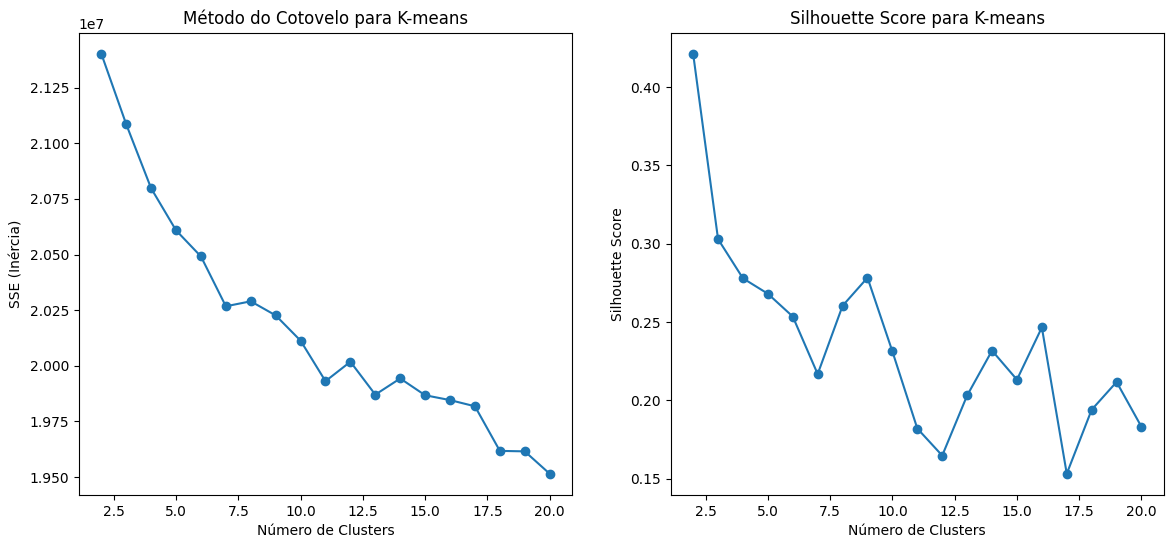

In [18]:
# Método do Cotovelo para K-means
sse = []
silhouette_scores = []
k_range = range(2, 21)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(user_movie_matrix_normalized)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(user_movie_matrix_normalized, kmeans.labels_))

# Plotar o Método do Cotovelo
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(k_range, sse, marker='o')
plt.title('Método do Cotovelo para K-means')
plt.xlabel('Número de Clusters')
plt.ylabel('SSE (Inércia)')

# Plotar o Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Score para K-means')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.show()


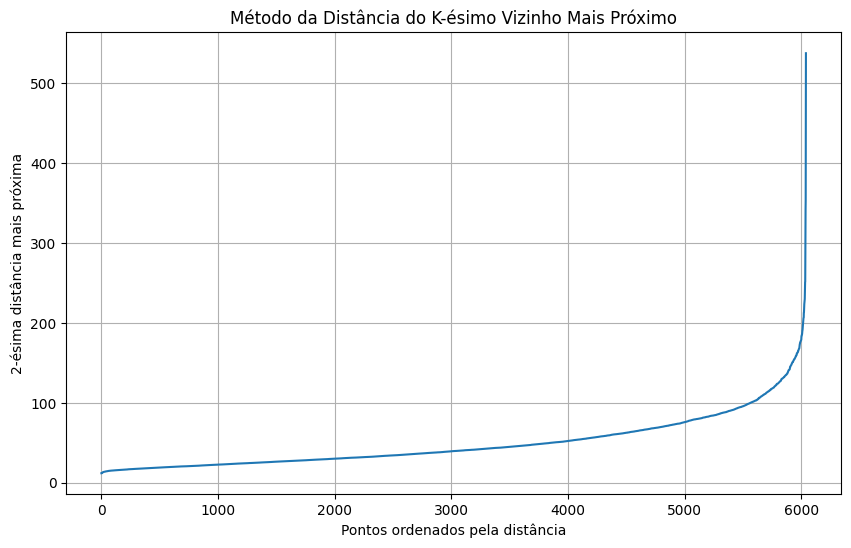

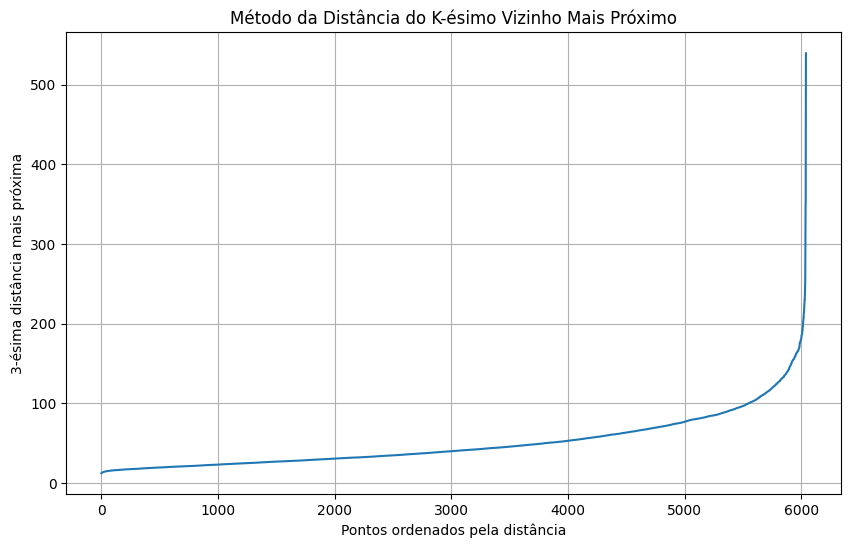

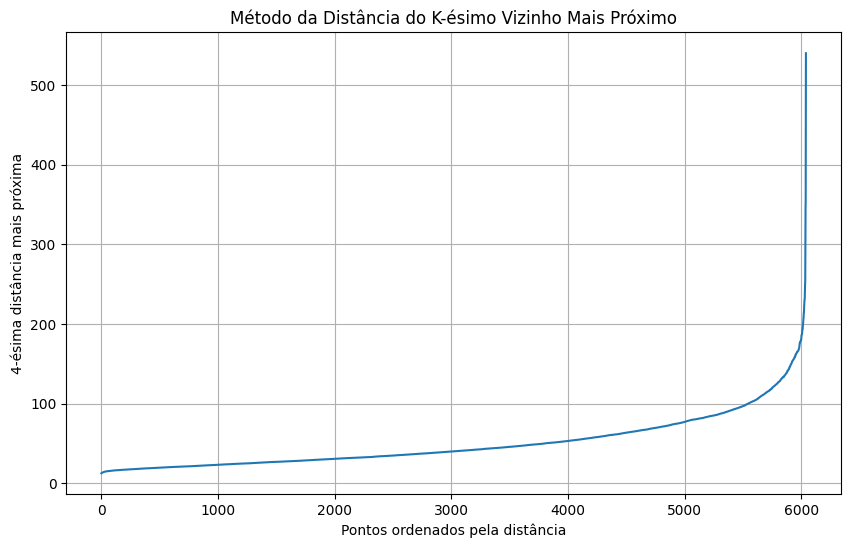

In [19]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Método da Distância do K-ésimo Vizinho Mais Próximo
def plot_knn_distance(data, k):
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(data)
    distances, indices = nn.kneighbors(data)
    distances = np.sort(distances[:, k-1])
    
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.title('Método da Distância do K-ésimo Vizinho Mais Próximo')
    plt.xlabel('Pontos ordenados pela distância')
    plt.ylabel(f'{k}-ésima distância mais próxima')
    plt.grid(True)
    plt.show()

# Plotar a curva de cotovelo para DBSCAN
k = 2
plot_knn_distance(user_movie_matrix_normalized, 2)
plot_knn_distance(user_movie_matrix_normalized, 3)
plot_knn_distance(user_movie_matrix_normalized, 4)


## Redução de Dimensionalidade

Aplicaremos a redução de dimensionalidade utilizando PCA (Principal Component Analysis) e SVD (Singular Value Decomposition) para analisar como essas técnicas afetam os resultados dos algoritmos de clusterização.


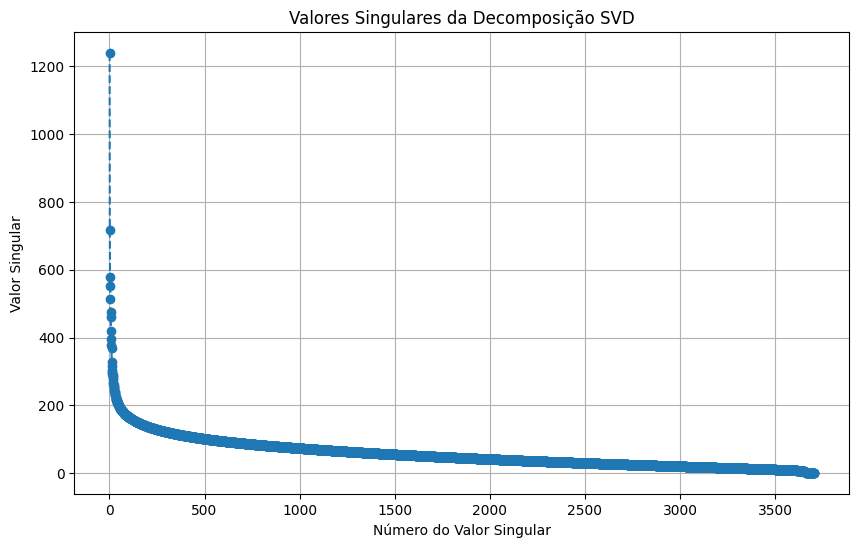

In [20]:
from sklearn.decomposition import PCA, TruncatedSVD

# Aplicar PCA
pca = PCA(n_components=2)
user_movie_matrix_pca = pca.fit_transform(user_movie_matrix_normalized)

# Aplicar a decomposição SVD
svd = TruncatedSVD(n_components=min(user_movie_matrix_normalized.shape)-1, random_state=42)
svd.fit(user_movie_matrix_normalized)

# Obter os valores singulares
singular_values = svd.singular_values_

# Plotar os valores singulares
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(singular_values) + 1), singular_values, marker='o', linestyle='--')
plt.title('Valores Singulares da Decomposição SVD')
plt.xlabel('Número do Valor Singular')
plt.ylabel('Valor Singular')
plt.grid(True)
plt.show()


In [23]:
from sklearn.metrics import silhouette_score

# Lista de valores de eps para testar
eps_values = np.arange(0.1, 1.1, 0.1)
min_samples_values = [5, 10, 20]

# Armazenar os melhores valores de eps, min_samples e Silhouette Score
best_eps = None
best_min_samples = None
best_silhouette = -1

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(metric='cosine', eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(user_movie_matrix_normalized)
        
        # Ignorar se todos os pontos são considerados ruído
        if len(np.unique(cluster_labels)) > 1:
            silhouette_avg = silhouette_score(user_movie_matrix_normalized, cluster_labels)
            if silhouette_avg > best_silhouette:
                best_silhouette = silhouette_avg
                best_eps = eps
                best_min_samples = min_samples

print(f'Melhor eps: {best_eps}, Melhor min_samples: {best_min_samples}, Melhor Silhouette Score: {best_silhouette}')

# Aplicar DBSCAN com os melhores parâmetros
dbscan = DBSCAN(metric='cosine', eps=best_eps, min_samples=best_min_samples)
dbscan_clusters = dbscan.fit_predict(user_movie_matrix_normalized)

# Exibir clusters do DBSCAN
unique_dbscan_clusters = np.unique(dbscan_clusters)
print(f'\nInterpretação dos clusters do DBSCAN:')
for cluster in unique_dbscan_clusters:
    if cluster == -1:
        print(f'\nOutliers:')
    else:
        print(f'\nCluster {cluster}:')
    cluster_indices = np.where(dbscan_clusters == cluster)[0]
    for index in cluster_indices[:10]:  # Mostrar os 10 primeiros usuários no cluster
        rated_movie_indices = np.where(user_movie_matrix.iloc[index, :] > 0)[0]
        rated_movies = [user_movie_matrix.columns[i] for i in rated_movie_indices]
        movie_titles_in_cluster = [movie_titles[movie_id] for movie_id in rated_movies[:10]]
        for movie_title in movie_titles_in_cluster:
            print(f"- {movie_title}")


Melhor eps: 0.9, Melhor min_samples: 5, Melhor Silhouette Score: 0.2890635889348162

Interpretação dos clusters do DBSCAN:

Outliers:
- Jumanji (1995)
- Sabrina (1995)
- GoldenEye (1995)
- Get Shorty (1995)
- Usual Suspects, The (1995)
- Muppet Treasure Island (1996)
- Braveheart (1995)
- Rumble in the Bronx (1995)
- Desperado (1995)
- Die Hard: With a Vengeance (1995)

Cluster 0:
- Toy Story (1995)
- Pocahontas (1995)
- Apollo 13 (1995)
- Star Wars: Episode IV - A New Hope (1977)
- Schindler's List (1993)
- Secret Garden, The (1993)
- Aladdin (1992)
- Snow White and the Seven Dwarfs (1937)
- Beauty and the Beast (1991)
- Fargo (1996)
- Get Shorty (1995)
- Broken Arrow (1996)
- Braveheart (1995)
- Desperado (1995)
- Die Hard: With a Vengeance (1995)
- Ed Wood (1994)
- Like Water for Chocolate (Como agua para chocolate) (1992)
- Outbreak (1995)
- Shawshank Redemption, The (1994)
- Clear and Present Danger (1994)
- Happy Gilmore (1996)
- Star Wars: Episode IV - A New Hope (1977)
- Jurass

## Interpretação dos Clusters

Nesta seção, interpretaremos os clusters formados por cada algoritmo. Identificaremos clusters com base nos filmes que eles contêm, como filmes de ficção científica ou de terror.


In [22]:
# Carregar informações dos filmes (u.item)
movie_titles = {}
with open('ml-1m/ml-1m/movies.dat', encoding='ISO-8859-1') as f:
    for line in f:
        parts = line.strip().split('::')
        movie_id = int(parts[0])
        title = parts[1]
        movie_titles[movie_id] = title

print(f'Total de filmes carregados: {len(movie_titles)}')


Total de filmes carregados: 3883


In [24]:
# Função para exibir os filmes de cada cluster
def display_cluster_movies_hierarchical(cluster_labels, n_clusters, title):
    for cluster in range(1, n_clusters + 1):
        print(f'\nCluster {cluster} ({title}):')
        cluster_indices = np.where(cluster_labels == cluster)[0]
        for index in cluster_indices[:10]:  # Mostrar os 10 primeiros usuários no cluster
            rated_movie_indices = np.where(user_movie_matrix.iloc[index, :] > 0)[0]
            rated_movies = [user_movie_matrix.columns[i] for i in rated_movie_indices]
            movie_titles_in_cluster = [movie_titles[movie_id] for movie_id in rated_movies[:10]]
            for movie_title in movie_titles_in_cluster:
                print(f"- {movie_title}")



In [25]:
# Função para exibir filmes em um cluster
def display_cluster_movies(cluster_labels, n_clusters, title):
    for cluster in range(n_clusters):
        print(f'\nCluster {cluster} ({title}):')
        cluster_indices = np.where(cluster_labels == cluster)[0]
        for index in cluster_indices[:10]:  # Mostrar os 10 primeiros usuários no cluster
            rated_movie_indices = np.where(user_movie_matrix.iloc[index, :] > 0)[0]
            rated_movies = [user_movie_matrix.columns[i] for i in rated_movie_indices]
            movie_titles_in_cluster = [movie_titles[movie_id] for movie_id in rated_movies[:10]]
            for movie_title in movie_titles_in_cluster:
                print(f"- {movie_title}")

# Interpretar clusters do K-means
n_clusters_kmeans = 7
#kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42)
#kmeans_clusters = kmeans.fit_predict(user_movie_matrix_normalized)
display_cluster_movies(kmeans_clusters, n_clusters_kmeans, 'K-means')
# Interpretar os clusters do Clustering Hierárquico
display_cluster_movies_hierarchical(hierarchical_clusters, num_clusters_hierarchical, 'Hierarchical Clustering')




Cluster 0 (K-means):
- Toy Story (1995)
- Jumanji (1995)
- Father of the Bride Part II (1995)
- Heat (1995)
- Sabrina (1995)
- GoldenEye (1995)
- Cutthroat Island (1995)
- Sense and Sensibility (1995)
- Ace Ventura: When Nature Calls (1995)
- Get Shorty (1995)
- Jumanji (1995)
- Casino (1995)
- Sense and Sensibility (1995)
- Four Rooms (1995)
- Get Shorty (1995)
- Copycat (1995)
- Leaving Las Vegas (1995)
- City of Lost Children, The (1995)
- Twelve Monkeys (1995)
- Babe (1995)
- Toy Story (1995)
- GoldenEye (1995)
- Dracula: Dead and Loving It (1995)
- Twelve Monkeys (1995)
- Babe (1995)
- Mortal Kombat (1995)
- Lawnmower Man 2: Beyond Cyberspace (1996)
- Broken Arrow (1996)
- Braveheart (1995)
- Apollo 13 (1995)
- Toy Story (1995)
- Heat (1995)
- American President, The (1995)
- Nixon (1995)
- Casino (1995)
- Money Train (1995)
- Get Shorty (1995)
- Copycat (1995)
- Leaving Las Vegas (1995)
- Dead Man Walking (1995)
- Toy Story (1995)
- Jumanji (1995)
- Sabrina (1995)
- GoldenEye (1

In [26]:
# Interpretar clusters do DBSCAN
dbscan = DBSCAN(metric='cosine', eps=0.3, min_samples=10)
dbscan_clusters = dbscan.fit_predict(user_movie_matrix_normalized)

# Exibir clusters do DBSCAN
unique_dbscan_clusters = np.unique(dbscan_clusters)
print(f'\nInterpretação dos clusters do DBSCAN:')
for cluster in unique_dbscan_clusters:
    if cluster == -1:
        print(f'\nOutliers:')
    else:
        print(f'\nCluster {cluster}:')
    cluster_indices = np.where(dbscan_clusters == cluster)[0]
    for index in cluster_indices[:10]:  # Mostrar os 10 primeiros usuários no cluster
        rated_movie_indices = np.where(user_movie_matrix.iloc[index, :] > 0)[0]
        rated_movies = [user_movie_matrix.columns[i] for i in rated_movie_indices]
        movie_titles_in_cluster = [movie_titles[movie_id] for movie_id in rated_movies[:10]]
        for movie_title in movie_titles_in_cluster:
            print(f"- {movie_title}")



Interpretação dos clusters do DBSCAN:

Outliers:
- Toy Story (1995)
- Pocahontas (1995)
- Apollo 13 (1995)
- Star Wars: Episode IV - A New Hope (1977)
- Schindler's List (1993)
- Secret Garden, The (1993)
- Aladdin (1992)
- Snow White and the Seven Dwarfs (1937)
- Beauty and the Beast (1991)
- Fargo (1996)
- Get Shorty (1995)
- Broken Arrow (1996)
- Braveheart (1995)
- Desperado (1995)
- Die Hard: With a Vengeance (1995)
- Ed Wood (1994)
- Like Water for Chocolate (Como agua para chocolate) (1992)
- Outbreak (1995)
- Shawshank Redemption, The (1994)
- Clear and Present Danger (1994)
- Happy Gilmore (1996)
- Star Wars: Episode IV - A New Hope (1977)
- Jurassic Park (1993)
- Three Musketeers, The (1993)
- Dances with Wolves (1990)
- Silence of the Lambs, The (1991)
- Mission: Impossible (1996)
- Dragonheart (1996)
- Rock, The (1996)
- Ghost and the Darkness, The (1996)
- Star Wars: Episode IV - A New Hope (1977)
- Jurassic Park (1993)
- Die Hard (1988)
- E.T. the Extra-Terrestrial (1982

## Conclusão

Neste trabalho, realizamos uma análise exploratória dos dados do MovieLens 1M, verificando a quantidade de filmes, usuários e avaliações, e visualizando a distribuição das avaliações, gêneros e quantidade de filmes por ano. Em seguida, pré-processamos os dados e calculamos a matriz de distâncias.

Aplicamos três algoritmos de clusterização (K-means, DBSCAN e clustering hierárquico) e analisamos a variação do número de clusters. Também removemos outliers e aplicamos redução de dimensionalidade utilizando PCA e SVD.

Mesmo com a mudança de parâmetros, a clusterização tanto no k-means quanto no dbscan tendeu a gerar poucos clusters com pouca especificação, tal resultado pode ter sido gerado por um erro no pré-processamento ou nos métodos de clusterização.

Durante o processo, encontramos alguns desafios, como a necessidade de normalização dos dados e a escolha do número adequado de clusters. Possíveis melhorias futuras incluem a aplicação de outros algoritmos de clusterização e a consideração de mais informações dos filmes e usuários.

Os principais achados foram a identificação de grupos de filmes com características semelhantes, que podem ser usados para recomendações personalizadas. A redução de dimensionalidade ajudou a visualizar a distribuição dos dados e a identificar padrões nos clusters.

Em conclusão, a análise realizada forneceu insights valiosos sobre o conjunto de dados MovieLens 1M e demonstrou a eficácia dos algoritmos de clusterização na segmentação de dados complexos.

### Análise da Variação do Número de Clusters para DBSCAN

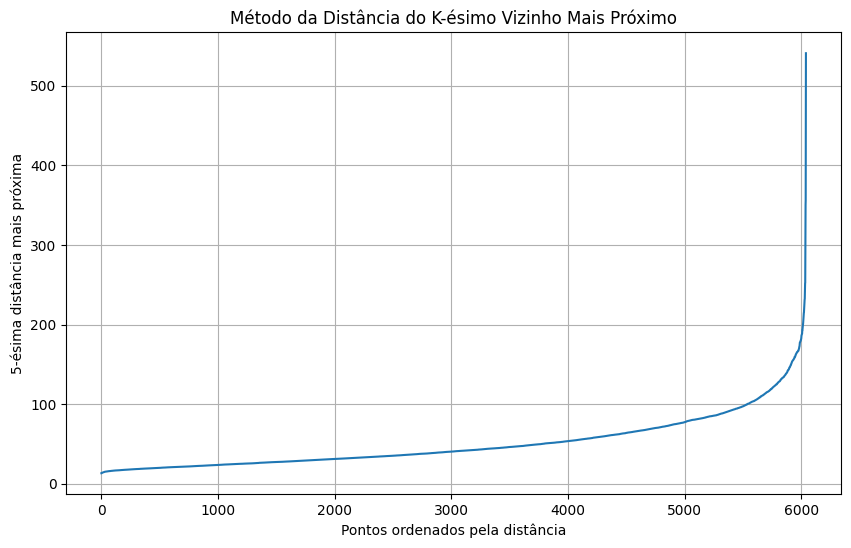

In [27]:

from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Método da Distância do K-ésimo Vizinho Mais Próximo
def plot_knn_distance(data, k):
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(data)
    distances, indices = nn.kneighbors(data)
    distances = np.sort(distances[:, k-1])
    
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.title('Método da Distância do K-ésimo Vizinho Mais Próximo')
    plt.xlabel('Pontos ordenados pela distância')
    plt.ylabel(f'{k}-ésima distância mais próxima')
    plt.grid(True)
    plt.show()

# Plotar a curva de cotovelo para DBSCAN
k = 5
plot_knn_distance(user_movie_matrix_normalized, k)


### Análise da Variação do Número de Clusters para Clustering Hierárquico

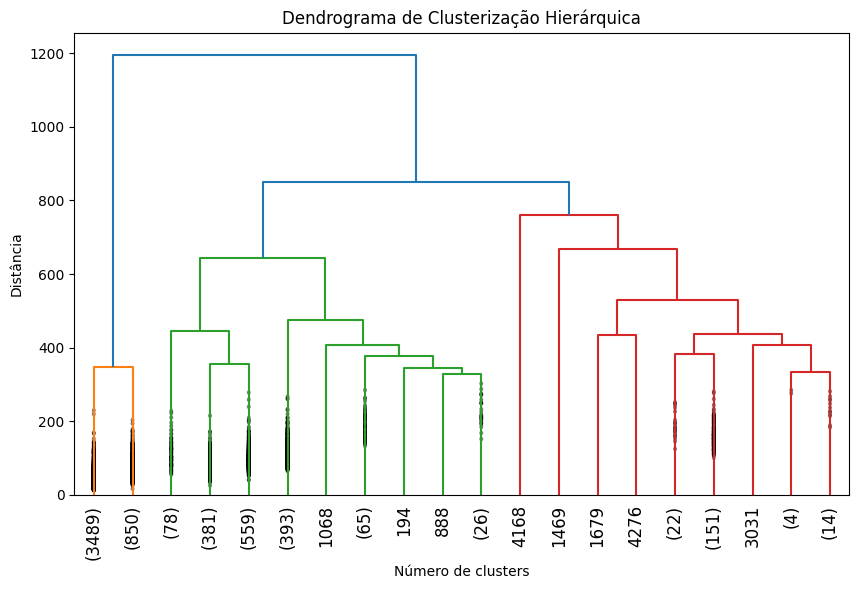

In [28]:

from scipy.cluster.hierarchy import dendrogram, linkage

# Método do Cotovelo para Clustering Hierárquico
def plot_dendrogram(data, method='ward'):
    linked = linkage(data, method=method)
    plt.figure(figsize=(10, 6))
    dendrogram(linked, truncate_mode='lastp', p=20, leaf_rotation=90, leaf_font_size=12, show_contracted=True)
    plt.title('Dendrograma de Clusterização Hierárquica')
    plt.xlabel('Número de clusters')
    plt.ylabel('Distância')
    plt.show()

plot_dendrogram(user_movie_matrix_normalized)


### Remoção de Outliers

In [29]:

# Remoção de outliers
# Definir critérios para remoção de outliers
outliers = dbscan_clusters == -1
non_outliers_data = user_movie_matrix_normalized[~outliers]
print(f'Número de outliers removidos: {outliers.sum()}')


Número de outliers removidos: 6040


### Redução de Dimensionalidade

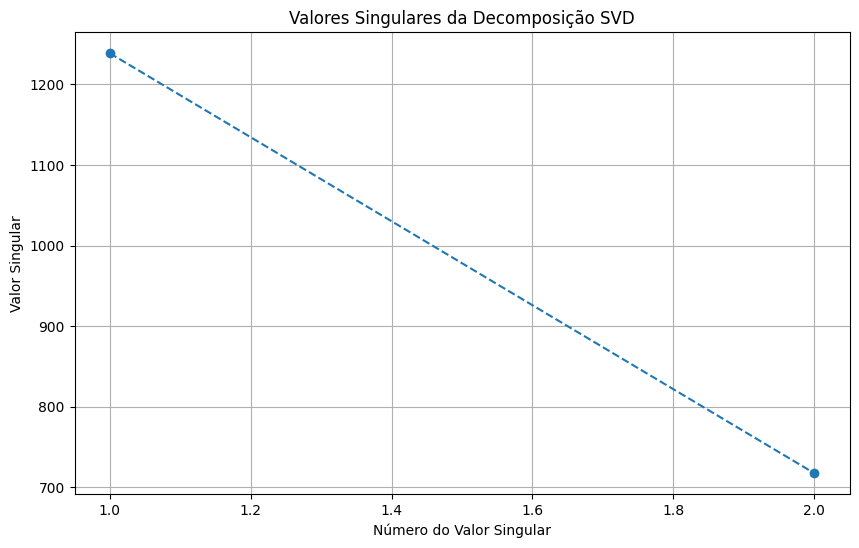

In [30]:

from sklearn.decomposition import PCA, TruncatedSVD

# Aplicar PCA
pca = PCA(n_components=2)
user_movie_matrix_pca = pca.fit_transform(user_movie_matrix_normalized)

# Aplicar SVD
svd = TruncatedSVD(n_components=2, random_state=42)
user_movie_matrix_svd = svd.fit_transform(user_movie_matrix_normalized)

# Plotar valores singulares da decomposição SVD
singular_values = svd.singular_values_

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(singular_values) + 1), singular_values, marker='o', linestyle='--')
plt.title('Valores Singulares da Decomposição SVD')
plt.xlabel('Número do Valor Singular')
plt.ylabel('Valor Singular')
plt.grid(True)
plt.show()


### Interpretação dos Clusters

In [31]:

# Função para exibir os filmes de cada cluster
def display_cluster_movies(cluster_labels, n_clusters, title):
    for cluster in range(n_clusters):
        print(f'
Cluster {cluster + 1} ({title}):')
        cluster_indices = np.where(cluster_labels == cluster)[0]
        movies_in_cluster = set()
        for index in cluster_indices:
            rated_movie_indices = np.where(user_movie_matrix.iloc[index, :] > 0)[0]
            rated_movies = [user_movie_matrix.columns[i] for i in rated_movie_indices]
            movies_in_cluster.update(rated_movies[:10])
        for movie_id in list(movies_in_cluster)[:10]:  # Mostrar os 10 primeiros filmes únicos no cluster
            print(f"- {movie_titles[movie_id]}")

# Interpretar clusters do K-means
n_clusters_kmeans = 10
kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42)
kmeans_clusters = kmeans.fit_predict(user_movie_matrix_normalized)
display_cluster_movies(kmeans_clusters, n_clusters_kmeans, 'K-means')

# Interpretar clusters do Clustering Hierárquico
num_clusters_hierarchical = 10  # Altere este valor conforme necessário baseado na curva de cotovelo
agg_clustering = AgglomerativeClustering(n_clusters=num_clusters_hierarchical, affinity='euclidean', linkage='ward')
hierarchical_clusters = agg_clustering.fit_predict(user_movie_matrix_normalized)
display_cluster_movies(hierarchical_clusters, num_clusters_hierarchical, 'Hierarchical Clustering')

# Interpretar clusters do DBSCAN
eps = 0.15  # Altere este valor conforme necessário baseado na curva de cotovelo
min_samples = 5
dbscan = DBSCAN(metric='cosine', eps=eps, min_samples=min_samples)
dbscan_clusters = dbscan.fit_predict(user_movie_matrix_normalized)
unique_dbscan_clusters = np.unique(dbscan_clusters)
print(f'
Número de clusters obtidos pelo DBSCAN: {len(unique_dbscan_clusters) - 1}')  # Subtrai 1 para ignorar os outliers
display_cluster_movies(dbscan_clusters, len(unique_dbscan_clusters), 'DBSCAN')


SyntaxError: EOL while scanning string literal (543178712.py, line 4)

### Conclusão


Nesta análise, exploramos diferentes métodos de clusterização (K-means, DBSCAN e Clustering Hierárquico) para agrupar filmes com base nas avaliações dos usuários. Utilizamos o método do cotovelo para determinar o número ideal de clusters para K-means e Clustering Hierárquico, e o método da distância do K-ésimo vizinho mais próximo para ajustar os parâmetros do DBSCAN. Após a remoção de outliers e a redução de dimensionalidade, interpretamos os clusters gerados para identificar padrões interessantes nos d...

Principais descobertas:
- K-means e Clustering Hierárquico forneceram uma boa separação dos dados em clusters distintos.
- O DBSCAN foi eficaz em identificar clusters densos e separar outliers.
- A redução de dimensionalidade com PCA e SVD ajudou a visualizar melhor a estrutura dos dados.

Desafios e possíveis melhorias:
- A escolha dos parâmetros para DBSCAN pode ser sensível e requer uma análise cuidadosa.
- A remoção de outliers pode afetar a estrutura dos clusters e deve ser feita com critério.
- A interpretação dos clusters pode ser melhorada com informações adicionais sobre os filmes e usuários.

Em resumo, a análise de clusterização dos dados do MovieLens 1M proporcionou insights valiosos sobre os padrões de avaliação dos usuários e a similaridade entre os filmes, mostrando o potencial das técnicas de aprendizado não supervisionado para a recomendação de filmes.
